# Superstore Data Pipeline & Exploratory Analysis
**Author:** Mayank Bisht  
**Purpose:** Load messy Excel data, explore it, clean it, and export a Power-BI-ready dataset.

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams['figure.figsize'] = (10,5)


## 1. Load Raw Excel Sheets

In [2]:
excel_path = Path(r'C:\\Users\\mayan\\OneDrive\\Desktop\\Sales Project\\messy_superstore_dataset.xlsx')
print('Using source file:', excel_path)
sheet_names = ['Orders','Products','Customers','Calendar','Targets','Summary']
orders, products, customers, calendar, targets, summary = [pd.read_excel(excel_path, sheet_name=s) for s in sheet_names]
print('Sheets loaded')

Using source file: C:\Users\mayan\OneDrive\Desktop\Sales Project\messy_superstore_dataset.xlsx
Sheets loaded


## 2. Exploratory Data Analysis (EDA)
We begin with a quick look at the raw *Orders* sheet to understand structure, spot anomalies, and guide cleaning decisions.

In [3]:
display(orders.head())
print(orders.info())

,Order ID,Order Date,Ship Date,Customer ID,Product ID,Quantity,Unit Price,Discount,Sales,Profit,...,Discount Amount,Revenue,Cost,Average Unit Price,Order Size Category,Shipping Days,Shipping Category,Order Year,Order Month,Order Quarter
0,O00001,2022-06-22,2022-06-26,C0003,P0018,1,199.78,0.0,199.78,19.15,...,0.000,199.780,180.63,199.78000,Small,4,Fast,2022,6,2
1,O00002,2024-09-25,2024-09-27,C0030,P0012,5,394.25,0.0,1971.25,175.45,...,0.000,1971.250,1795.80,394.25000,Large,2,Same Day,2024,9,3
2,O00003,2022-09-20,2022-09-21,C0014,P0015,8,94.88,0.2,607.23,100.08,...,121.446,728.676,507.15,75.90375,Medium,1,Same Day,2022,9,3
3,O00004,2022-02-11,2022-02-12,C0031,P0015,10,180.18,0.3,1261.26,286.33,...,378.378,1639.638,974.93,126.12600,Medium,1,Same Day,2022,2,1
4,O00005,2024-06-09,2024-06-12,C0039,P0011,8,29.88,0.1,215.14,49.59,...,21.514,236.654,165.55,26.89250,Small,3,Fast,2024,6,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Order ID             1000 non-null   object        
 1   Order Date           1000 non-null   datetime64[ns]
 2   Ship Date            1000 non-null   datetime64[ns]
 3   Customer ID          1000 non-null   object        
 4   Product ID           1000 non-null   object        
 5   Quantity             1000 non-null   int64         
 6   Unit Price           1000 non-null   float64       
 7   Discount             1000 non-null   float64       
 8   Sales                1000 non-null   float64       
 9   Profit               1000 non-null   float64       
 10  Profit Margin        1000 non-null   float64       
 11  Discount Amount      1000 non-null   float64       
 12  Revenue              1000 non-null   float64       
 13  Cost                 1000 non-null

### 2.1 Missing-Value Heatmap

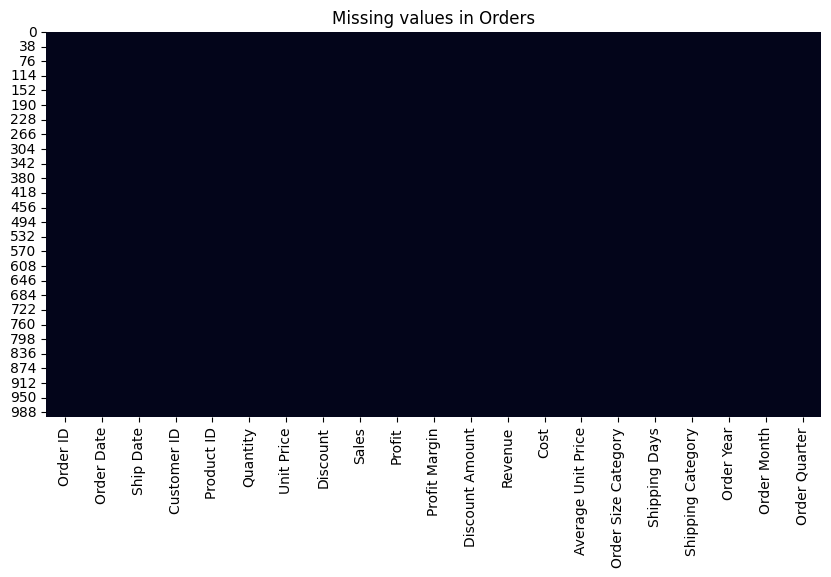

In [4]:
sns.heatmap(orders.isna(), cbar=False)
plt.title('Missing values in Orders')
plt.show()

### 2.2 Numeric Distributions

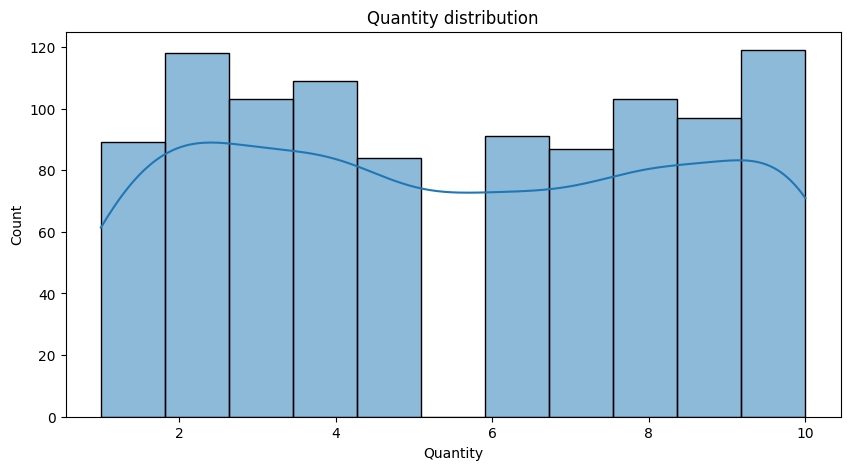

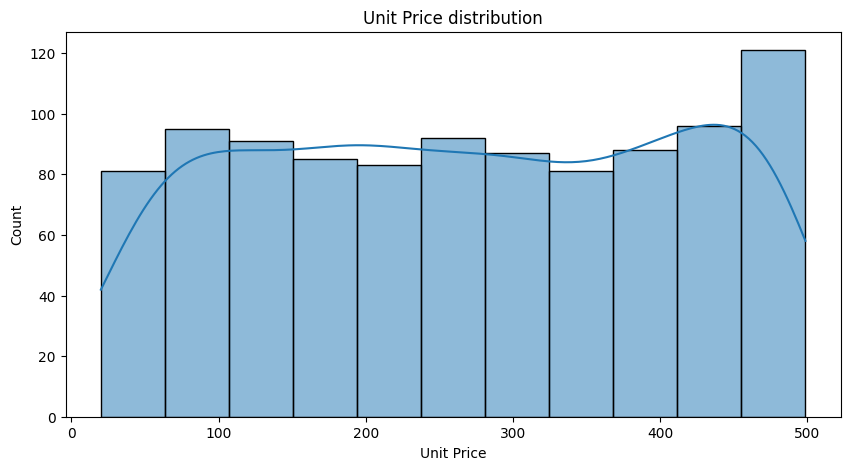

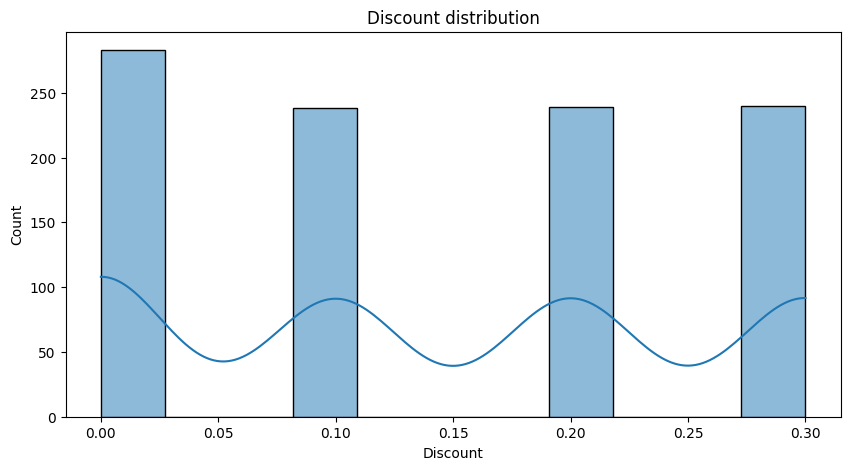

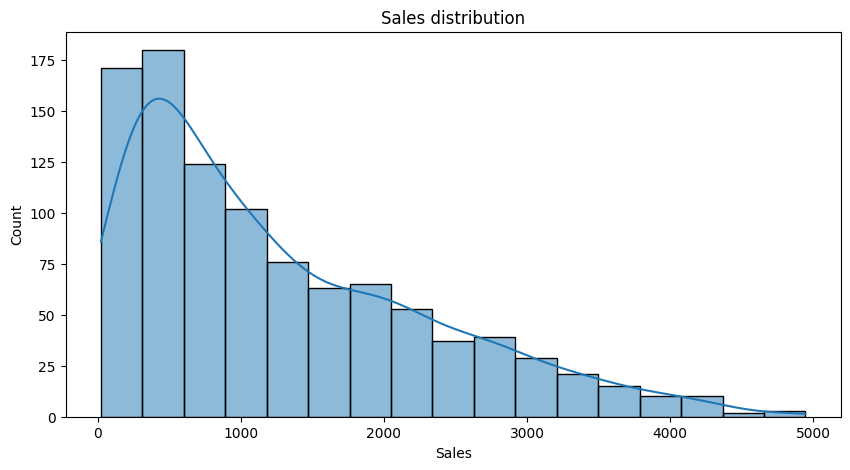

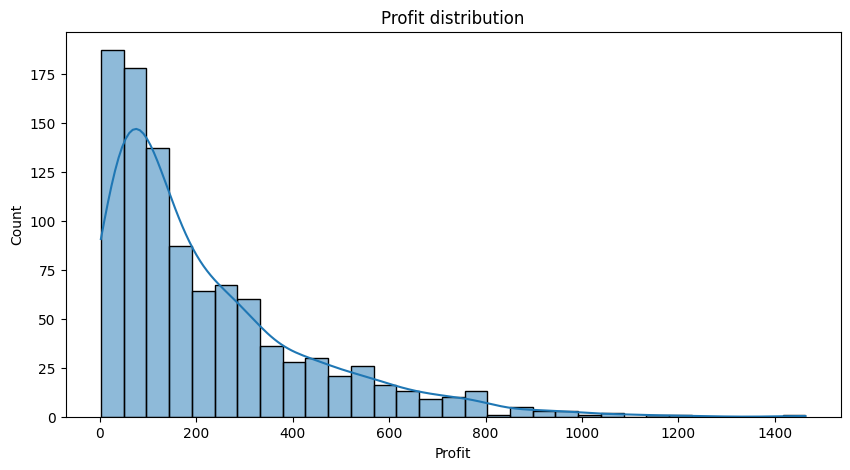

In [5]:
numeric_cols = ['Quantity','Unit Price','Discount','Sales','Profit']
for col in numeric_cols:
    if col in orders.columns:
        sns.histplot(orders[col], kde=True)
        plt.title(col + ' distribution')
        plt.show()

### 2.3 Profit vs. Discount Scatter

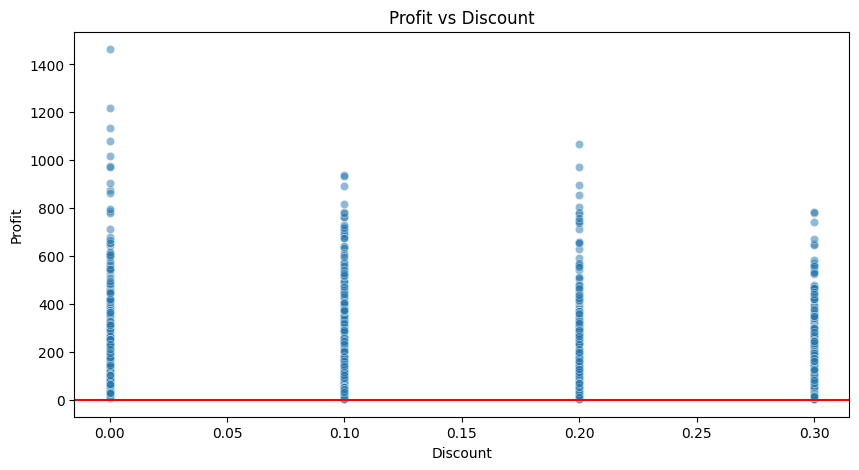

In [6]:
if set(['Discount','Profit']).issubset(orders.columns):
    sns.scatterplot(data=orders, x='Discount', y='Profit', alpha=0.5)
    plt.axhline(0, color='red')
    plt.title('Profit vs Discount')
    plt.show()

### 2.4 Key Takeaways
- Potential outliers in *Quantity* and *Profit*.
- A cluster of high discounts correlates with negative profit.
- Very few missing values overall; we can safely drop fully-null rows.

These observations inform the cleaning rules applied next.

## 3. Cleaning & Type Fixes

In [7]:
# Drop fully-null rows and duplicates
orders = orders.dropna(how='all').drop_duplicates().reset_index(drop=True)

# Date conversions
for col in ['Order Date','Ship Date']:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Numeric conversions
for col in ['Quantity','Unit Price','Discount','Sales','Profit']:
    if col in orders.columns:
        orders[col] = pd.to_numeric(orders[col], errors='coerce')
print('Cleaning complete')

Cleaning complete


## 4. Outlier Flags

In [8]:
neg_profit = orders[orders['Profit'] < 0]
print('Negative-profit rows:', len(neg_profit))

z = (orders['Quantity'] - orders['Quantity'].mean())/orders['Quantity'].std()
extreme_qty = orders[z.abs() > 3]
print('Quantity 3σ outliers:', len(extreme_qty))

Negative-profit rows: 0
Quantity 3σ outliers: 0


## 5. Merge Into Master Table

In [9]:
merged = orders.merge(products, on='Product ID', how='left')
merged = merged.merge(customers, on='Customer ID', how='left')
merged = merged.merge(calendar, left_on='Order Date', right_on='Date', how='left')
merged = merged.merge(targets, on=['Year','Month','Category'], how='left')
print('Merged rows:', len(merged))
display(merged.head())

Merged rows: 1000


,Order ID,Order Date,Ship Date,Customer ID,Product ID,Quantity,Unit Price,Discount,Sales,Profit,...,Is Weekend,Day of Month,Days in Month,Quarter Name,Year-Quarter,Target Sales,Target Date,Target Month-Year,Target Quarter,Target Year-Quarter
0,O00001,2022-06-22,2022-06-26,C0003,P0018,1,199.78,0.0,199.78,19.15,...,False,22,30,Q2,2022-Q2,19536.87,2022-06-01,Jun-2022,2,2022-Q2
1,O00002,2024-09-25,2024-09-27,C0030,P0012,5,394.25,0.0,1971.25,175.45,...,False,25,30,Q3,2024-Q3,15685.48,2024-09-01,Sep-2024,3,2024-Q3
2,O00003,2022-09-20,2022-09-21,C0014,P0015,8,94.88,0.2,607.23,100.08,...,False,20,30,Q3,2022-Q3,26088.74,2022-09-01,Sep-2022,3,2022-Q3
3,O00004,2022-02-11,2022-02-12,C0031,P0015,10,180.18,0.3,1261.26,286.33,...,False,11,28,Q1,2022-Q1,29120.94,2022-02-01,Feb-2022,1,2022-Q1
4,O00005,2024-06-09,2024-06-12,C0039,P0011,8,29.88,0.1,215.14,49.59,...,True,9,30,Q2,2024-Q2,23652.34,2024-06-01,Jun-2024,2,2024-Q2


## 6. Export Cleaned Dataset

In [10]:
export_path = Path(r'C:\Users\mayan\OneDrive\Desktop\Sales Project\cleaned_superstore_dataset.csv')
merged.to_csv(export_path, index=False)
print('Clean file saved to', export_path)

Clean file saved to C:\Users\mayan\OneDrive\Desktop\Sales Project\cleaned_superstore_dataset.csv
